In [29]:
import pandas as pd
import seaborn as sns
sns.set_style('dark')
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF

import pyLDAvis
import pyLDAvis.gensim_models
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

import gensim
from gensim.utils import simple_preprocess

import pickle

import warnings
warnings.filterwarnings('ignore',category=DeprecationWarning)
warnings.filterwarnings('ignore',category=FutureWarning)

In [7]:
with open('data/df.pickle', 'rb') as f:
    df = pickle.load(f)
df

,medical_specialty,transcription,transcript_gensim,gensim_cleaned
0,Cardiovascular / Pulmonary,"2-D M-MODE: , ,1. Left atrial enlargement wit...","[mode, leave, atrial, enlargement, leave, atri...","[mode, leave, atrial, enlargement, leave, atri..."
1,Cardiovascular / Pulmonary,1. The left ventricular cavity size and wall ...,"[leave, ventricular, cavity, size, wall, thick...","[leave, ventricular, cavity, size, wall, thick..."
2,Cardiovascular / Pulmonary,"2-D ECHOCARDIOGRAM,Multiple views of the heart...","[echocardiogram, multiple, view, heart, great,...","[echocardiogram, multiple, view, heart, great,..."
3,Cardiovascular / Pulmonary,"DESCRIPTION:,1. Normal cardiac chambers size....","[description, normal, cardiac, chamber, size, ...","[description, normal, cardiac, chamber, size, ..."
4,Cardiovascular / Pulmonary,"2-D STUDY,1. Mild aortic stenosis, widely calc...","[study, mild, aortic, stenosis, widely, calcif...","[study, mild, aortic, stenosis, widely, calcif..."
...,...,...,...,...
3709,Cardiovascular / Pulmonary,"INDICATION: , Chest pain.,TYPE OF TEST: , Aden...","[indication, chest, pain, type, test, adenosin...","[indication, chest, pain, type, test, adenosin..."
3710,Cardiovascular / Pulmonary,"CHIEF COMPLAINT: , Chest pain.,HISTORY OF PRES...","[chief, complaint, chest, pain, history, prese...","[chief, complaint, chest, pain, history, prese..."
3711,Cardiovascular / Pulmonary,"HISTORY OF PRESENT ILLNESS: , The patient is a...","[history, present, illness, patient, year, old...","[history, present, illness, patient, year, old..."
3712,Cardiovascular / Pulmonary,"HISTORY OF PRESENT ILLNESS: , Mr. ABC is a 60-...","[history, present, illness, mr, abc, year, old...","[history, present, illness, mr, abc, year, old..."


# Top 25 Words Overall

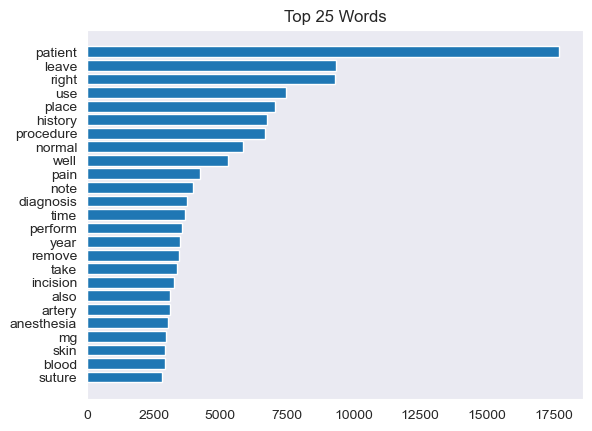

In [8]:
word_count = {}
for doc in df['gensim_cleaned']:
    for word in doc:
        if word not in word_count:
            word_count[word]=1
        if word in word_count:
            word_count[word]+=1
word_count = dict(sorted(word_count.items(), key=lambda x: x[1], reverse=True))
word_count = list(word_count.items())[:25]
keys = [item[0] for item in word_count]
values = [item[1] for item in word_count]
fig,ax = plt.subplots()
ax.barh(keys, values)
ax.invert_yaxis()
ax.set_title('Top 25 Words');

# Top 25 Words by Specialty

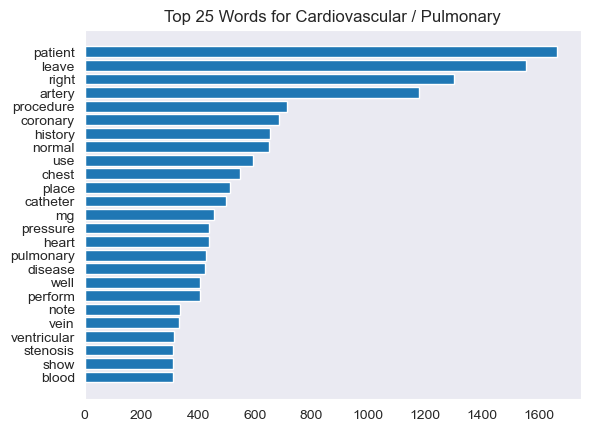

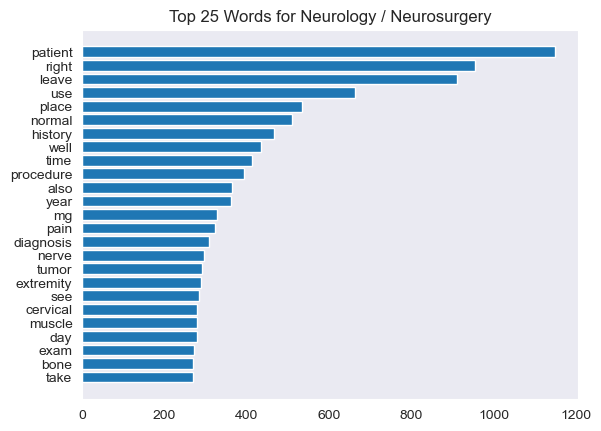

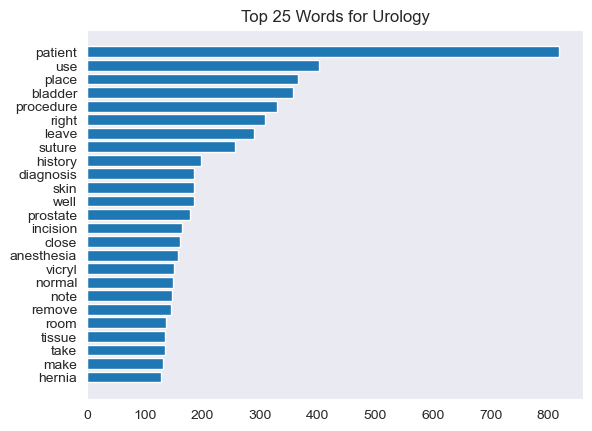

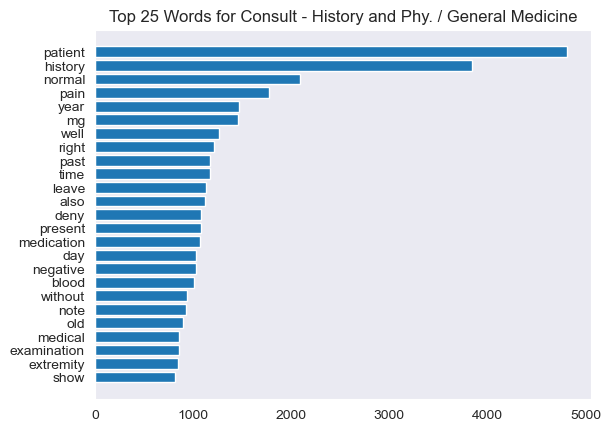

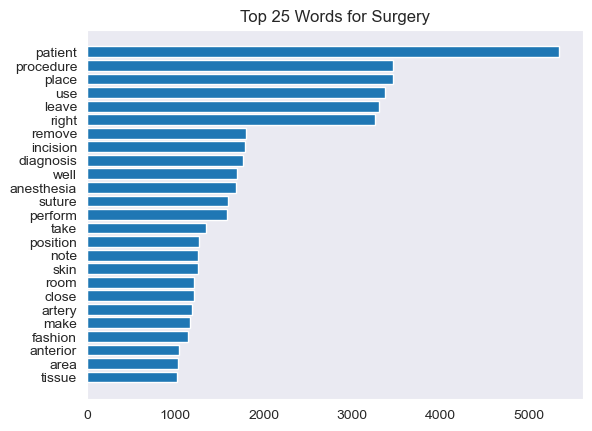

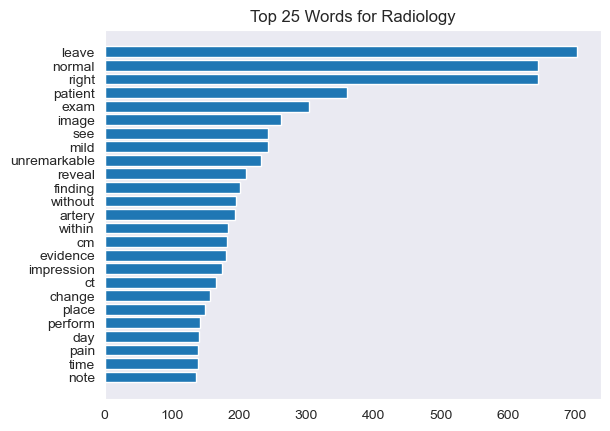

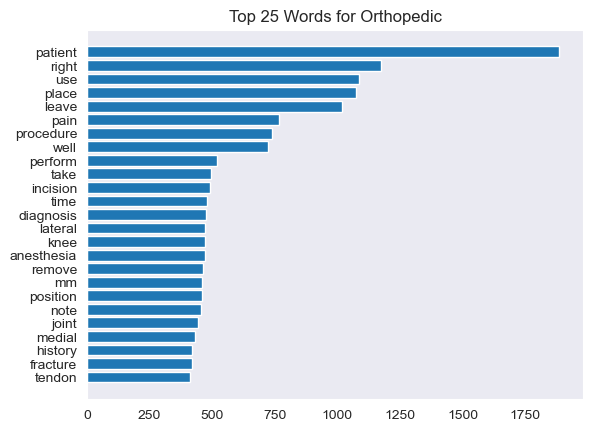

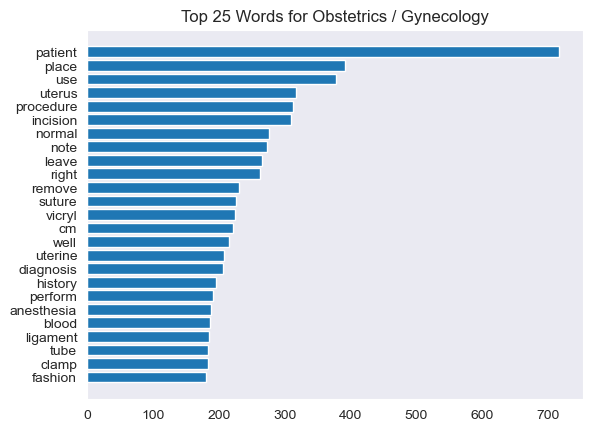

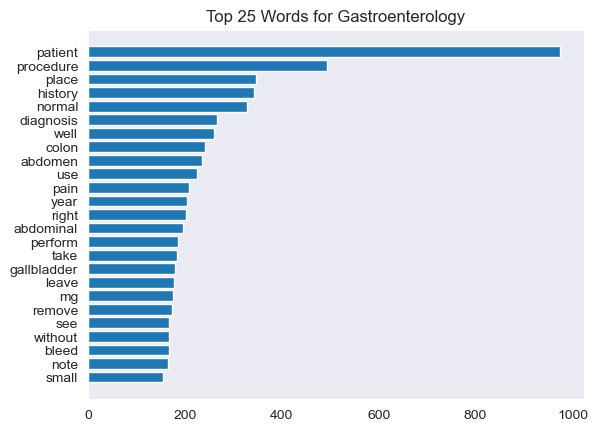

In [33]:
def count_by_spec(df,spec):
    df_spec = df[df['medical_specialty']==spec]
    word_count = {}
    for doc in df_spec['gensim_cleaned']:
        for word in doc:
            if word not in word_count:
                word_count[word]=1
            if word in word_count:
                word_count[word]+=1
    word_count = dict(sorted(word_count.items(), key=lambda x: x[1], reverse=True))
    word_count = list(word_count.items())[:25]
    keys = [item[0] for item in word_count]
    values = [item[1] for item in word_count]
    fig,ax = plt.subplots(1,1)
    ax.barh(keys, values)
    ax.invert_yaxis()
    ax.set_title(f'Top 25 Words for {spec}')
    
for spec in df['medical_specialty'].unique():
    count_by_spec(df,spec)

# Function to obtain bigrams/trigrams

In [16]:
def num_ngrams(dictionary):
    words = list(dictionary.token2id.keys())
    ngrams = [word for word in words if '_' in word]
    print('Number of ngrams: ', len(ngrams))
    
def observe_ngrams(df,count=int,thresh=int):
    bigram_phrases = gensim.models.phrases.Phrases(df['gensim_cleaned'], min_count=count, threshold=thresh)
    trigram_phrases = gensim.models.phrases.Phrases(bigram_phrases[df['gensim_cleaned']],min_count=count,threshold=thresh)

    bigrams = gensim.models.phrases.Phraser(bigram_phrases)
    trigrams = gensim.models.phrases.Phraser(trigram_phrases)
    
    ngrammed = df['gensim_cleaned'].apply(lambda x: trigrams[bigrams[x]])
    
    ngram_dict = gensim.corpora.Dictionary(ngrammed)
    print('Length of dictionary: ', len(ngram_dict))
    num_ngrams(ngram_dict)
    return ngrammed, ngram_dict

# Top 25 Words Overall

Length of dictionary:  17458
Number of ngrams:  2114


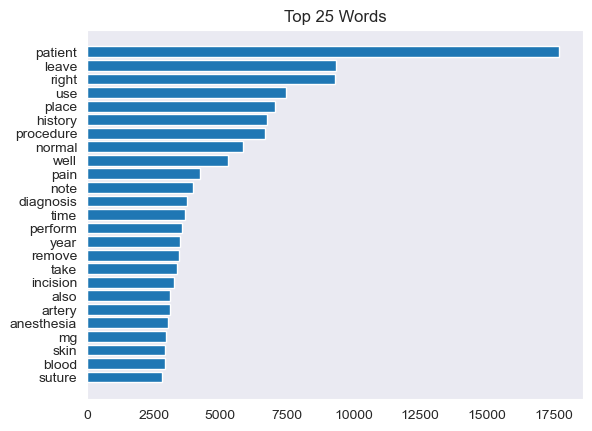

In [17]:
df['ngrammed'], ngram_dict = observe_ngrams(df,count=25,thresh=10)

word_count = {}
for doc in df['ngrammed']:
    for word in doc:
        if word not in word_count:
            word_count[word]=1
        if word in word_count:
            word_count[word]+=1
word_count = dict(sorted(word_count.items(), key=lambda x: x[1], reverse=True))
fig,ax = plt.subplots(1,1)
ax.barh(keys, values)
ax.invert_yaxis()
ax.set_title('Top 25 Words');

# Top 25 Words by Specialty

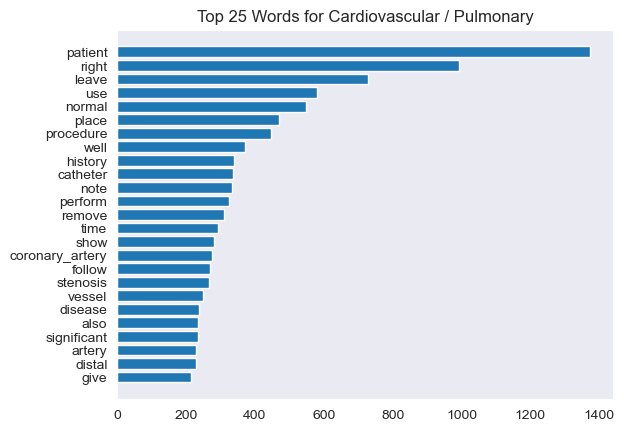

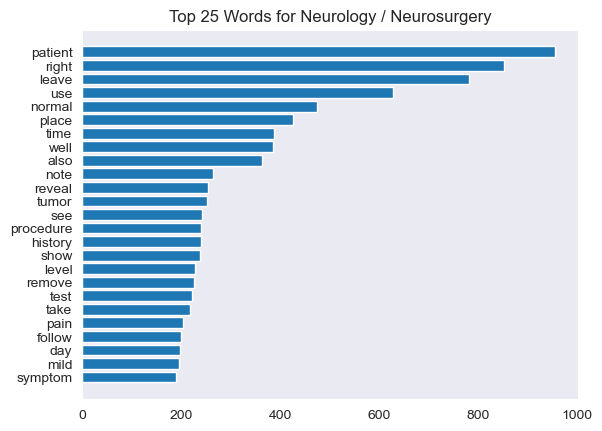

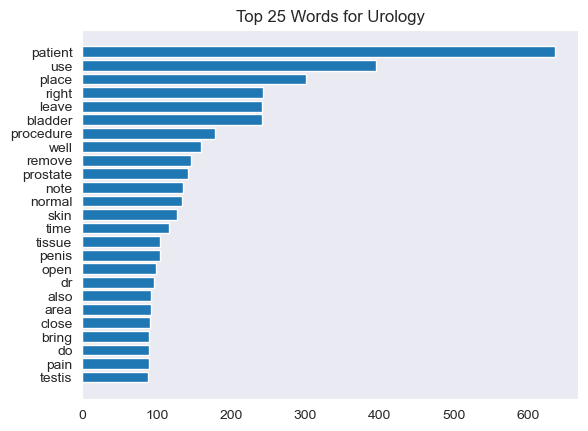

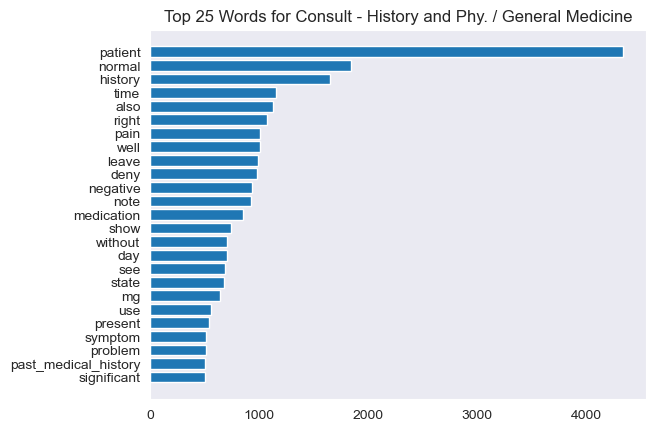

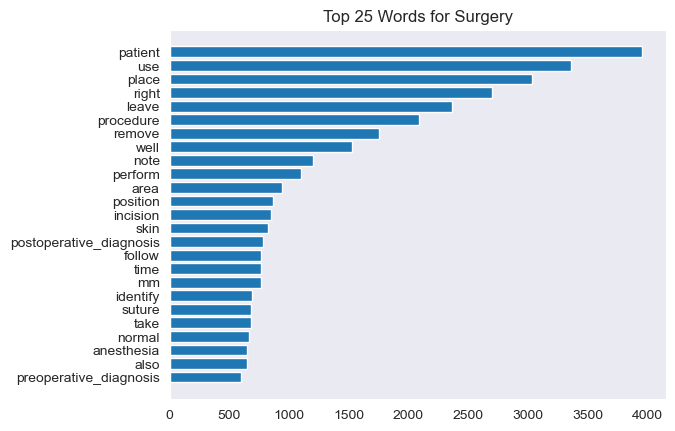

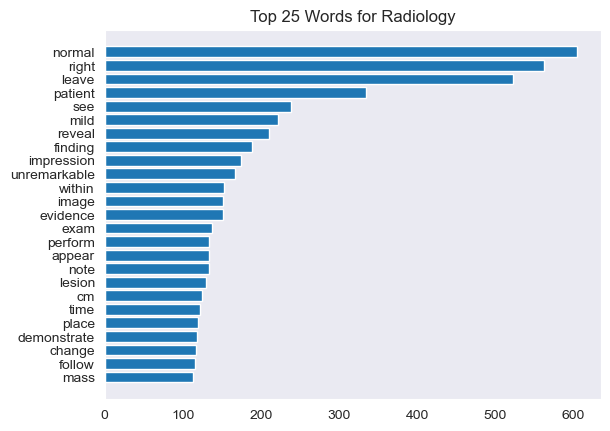

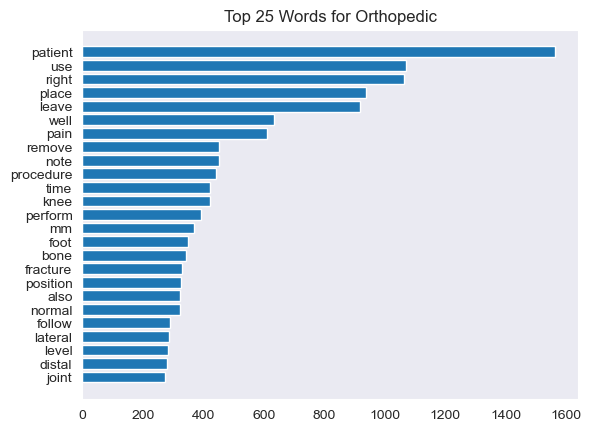

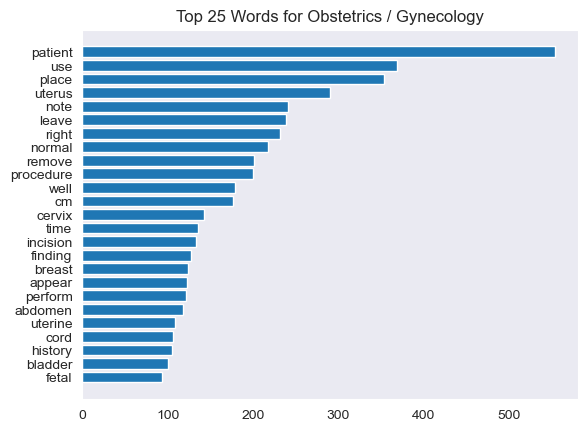

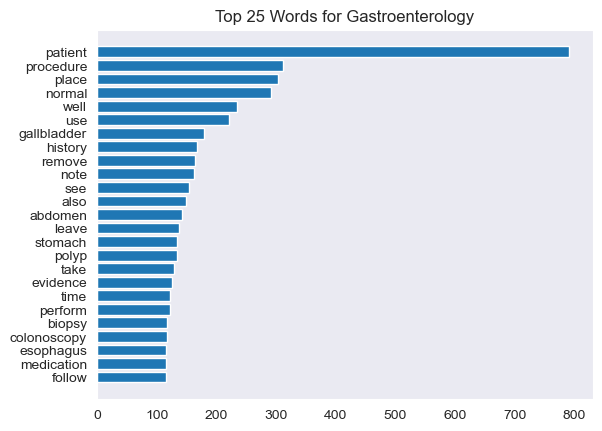

In [43]:
def count_by_spec_ngrammed(df,spec,col):
    df_spec = df[df['medical_specialty']==spec]
    word_count = {}
    for doc in df_spec[col]:
        for word in doc:
            if word not in word_count:
                word_count[word]=1
            if word in word_count:
                word_count[word]+=1
    word_count = dict(sorted(word_count.items(), key=lambda x: x[1], reverse=True))
    word_count = list(word_count.items())[:25]
    keys = [item[0] for item in word_count]
    values = [item[1] for item in word_count]
    fig,ax = plt.subplots(1,1)
    ax.barh(keys, values)
    ax.invert_yaxis()
    ax.set_title(f'Top 25 Words for {spec}')
    
for spec in df['medical_specialty'].unique():
    count_by_spec_ngrammed(df,spec,'ngrammed')

# Topic Model Word Weights by Topic

In [23]:
vec = TfidfVectorizer(min_df=5,max_df=0.95)
ngrammed_vecd = vec.fit_transform(df['ngrammed'].apply(lambda x: ' '.join(x)))

topic_model = NMF(n_components = 9,random_state=42)
topic_mat = topic_model.fit_transform(ngrammed_vecd)

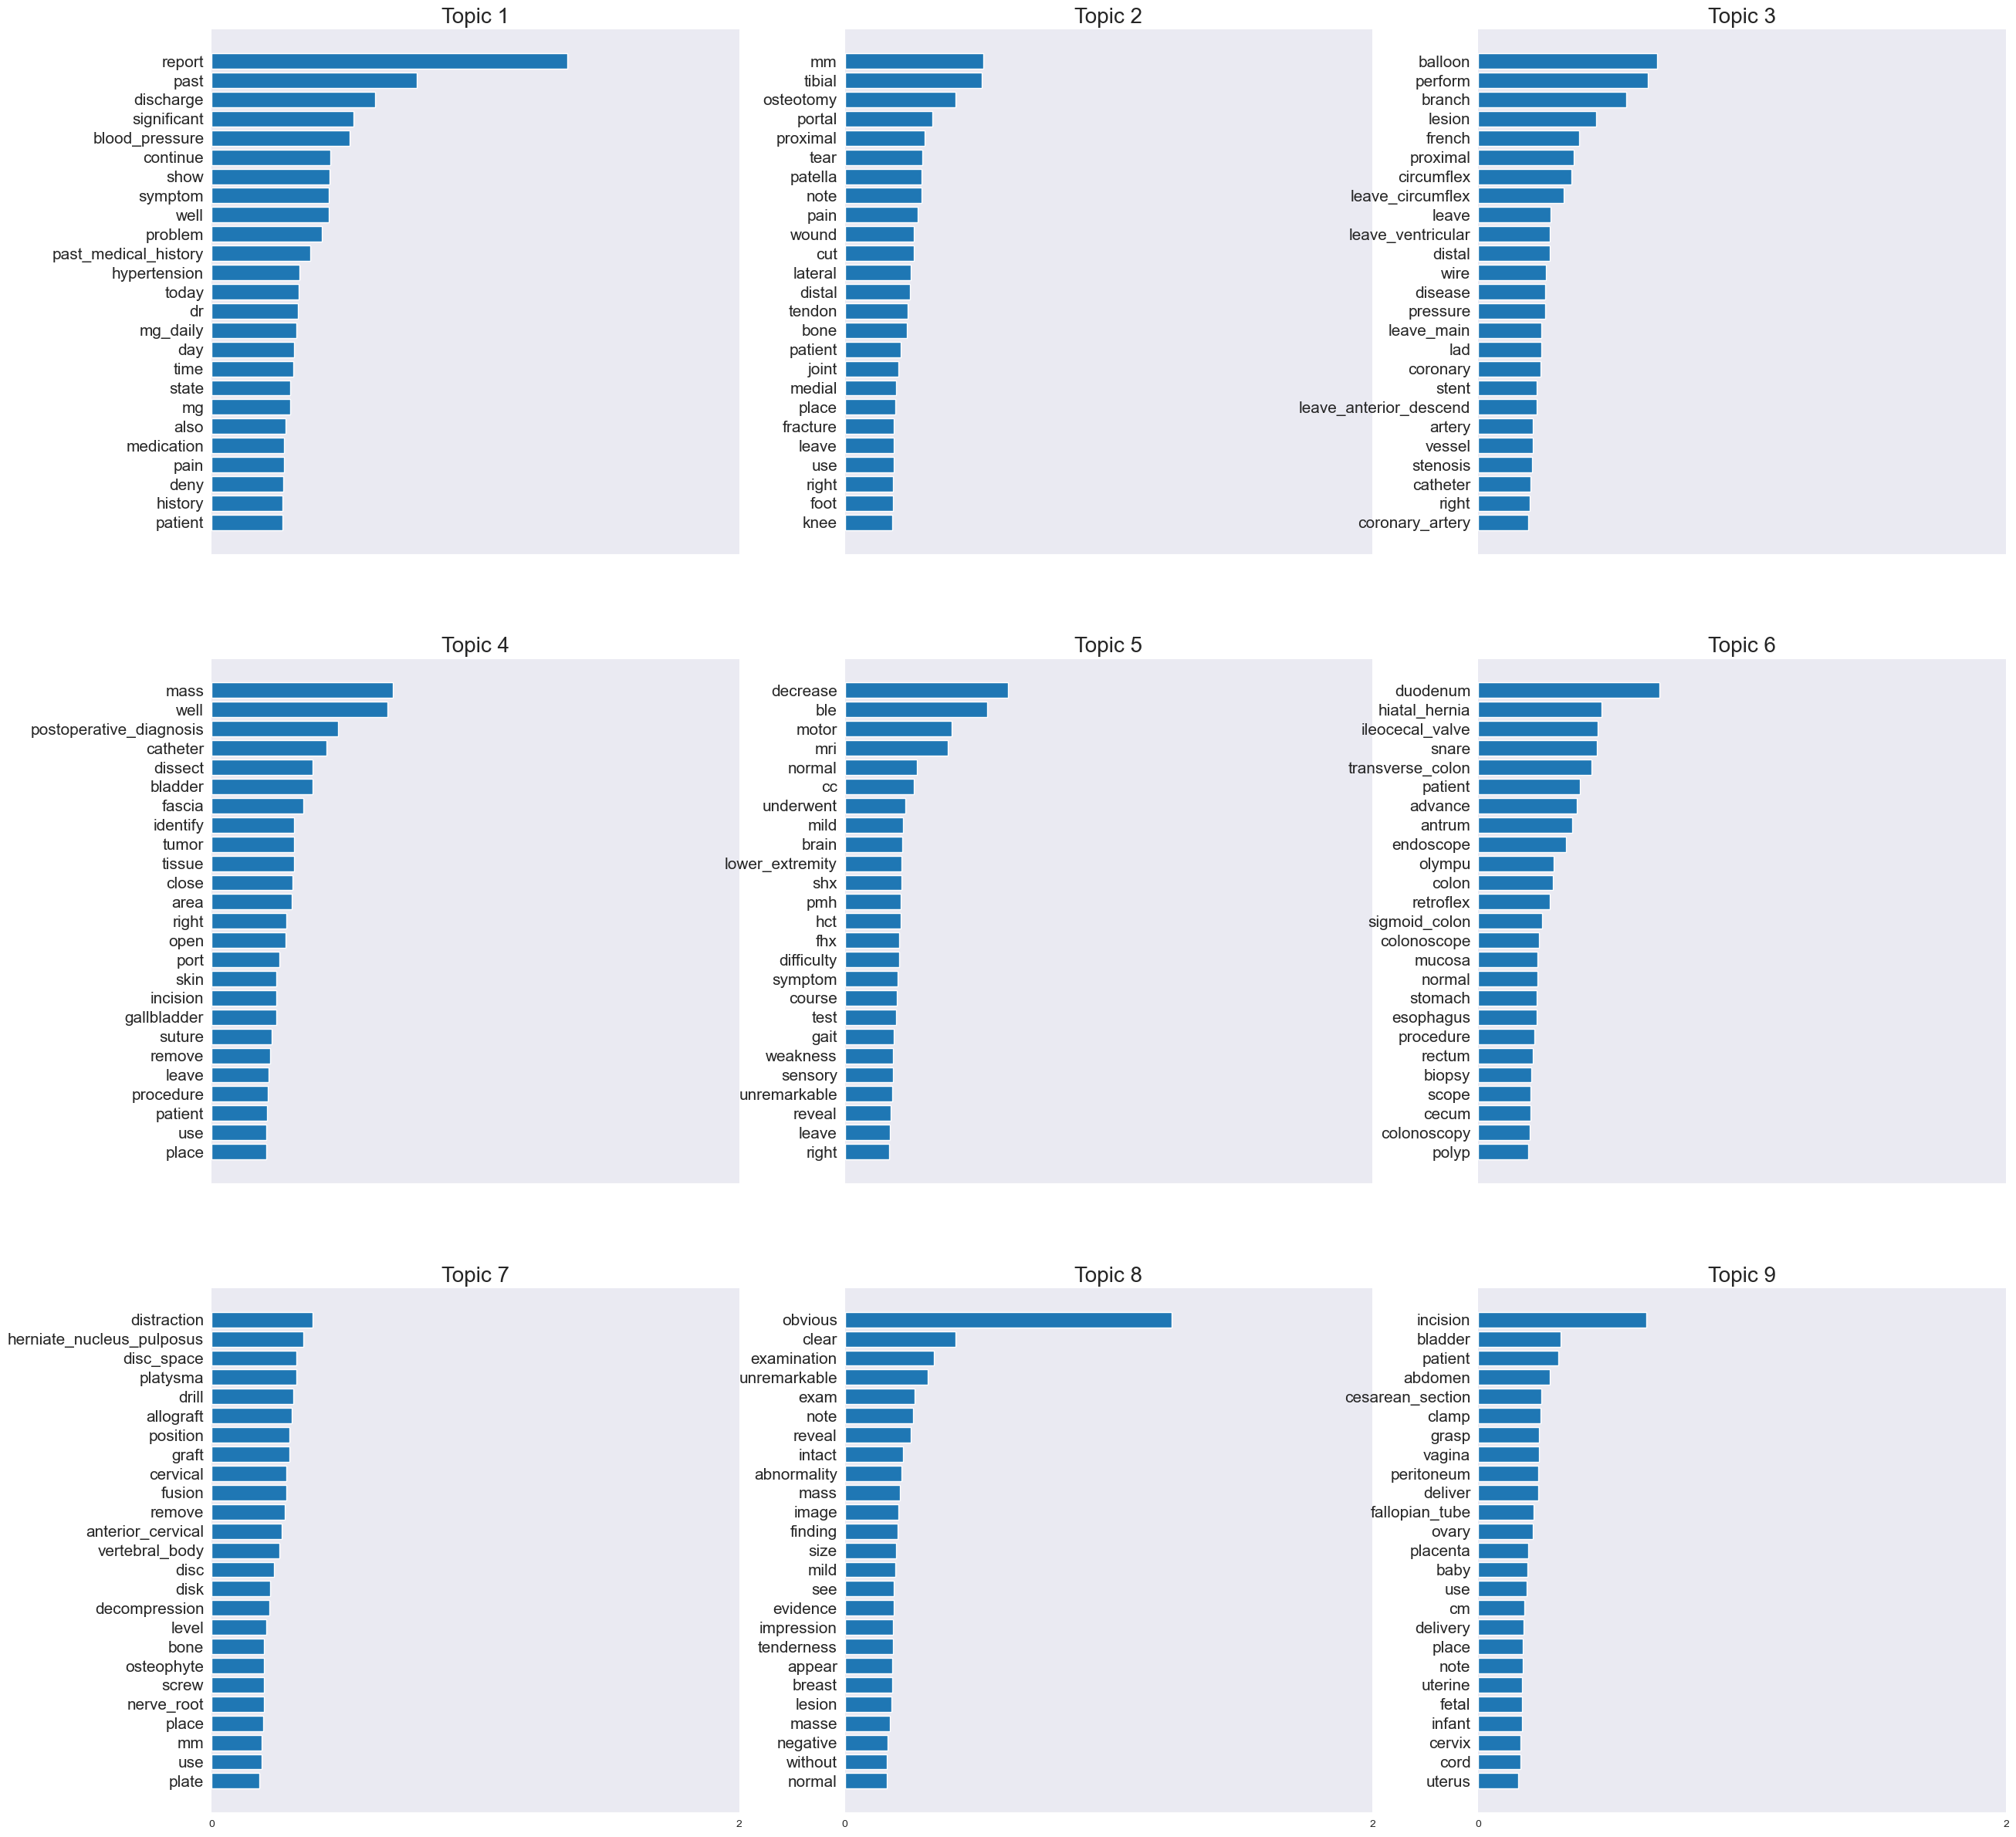

In [41]:
fig,axes = plt.subplots(3,3,figsize=(30,30),sharex=True)
for i, axis in enumerate(axes.flatten()):
    topic = topic_model.components_[i]
    top_words = [vec.get_feature_names()[j] for j in topic.argsort()[-25:]]
    top_features_ind = topic.argsort()[: -25 - 1 : -1]
    weight = topic[top_features_ind]
    ax=axis
    ax.barh(top_words,weight)
    ax.invert_yaxis()
    ax.tick_params(axis='y', labelsize=15)
    ax.set_title(f'Topic {i+1}',fontsize=20)
    for i in "top right left".split():
            ax.spines[i].set_visible(False)
    
    ax.set_xlim([0, 2])
    ax.set_xticks([0, 2])

# pyLDAvis

In [31]:
vis = pyLDAvis.sklearn.prepare(topic_model,ngrammed_vecd,vec)
vis

/Users/evan/miniforge3/envs/tf_env/lib/python3.10/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/Users/evan/miniforge3/envs/tf_env/lib/python3.10/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/Users/evan/miniforge3/envs/tf_env/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/Users/evan/miniforge3/envs/tf_env/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/Users/evan/miniforge3/envs/tf_env/lib/python3.10/site-packages/

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.214008 -0.051239       1        1  20.049672
3     -0.180058  0.031204       2        1  16.988102
7      0.214280  0.011253       3        1  11.781782
4      0.212315 -0.160382       4        1  11.560223
1     -0.163747 -0.125552       5        1  11.027405
2      0.032149  0.166778       6        1   7.724608
6     -0.179527 -0.155274       7        1   7.618220
8     -0.153748  0.043004       8        1   6.903771
5      0.004328  0.240208       9        1   6.346215, topic_info=                 Term        Freq       Total Category  logprob  loglift
5839           normal  131.000000  131.000000  Default  30.0000  30.0000
6669            polyp   35.000000   35.000000  Default  29.0000  29.0000
1878  coronary_artery   37.000000   37.000000  Default  28.0000  28.0000
1311         catheter   45.000000   45.000000  Default  27.0000  27.0000
7512            right  128.000000  128.000000  Default  26.0000  26.0000
...               ...         ...         ...      ...      ...      ...
184           advance   10.935706   22.110329   Topic9  -5.3372   2.0533
5839           normal   14.691091  131.618404   Topic9  -5.0420   0.5646
232               air    8.416554   12.383046   Topic9  -5.5990   2.3712
6324          patient   10.641622  152.558058   Topic9  -5.3644   0.0945
1574               cm    8.529710   43.281712   Topic9  -5.5856   1.1331

[781 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
9         1  0.198462      abdomen
9         2  0.330771      abdomen
9         3  0.165385      abdomen
9         8  0.297694      abdomen
38        1  0.086994  abnormality
...     ...       ...          ...
9700      2  0.292371        wound
9700      5  0.454799        wound
9700      7  0.194914        wound
9720      3  0.873877  xii_grossly
9755      1  0.962494    yesterday

[1342 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 8, 5, 2, 3, 7, 9, 6])